# F1 Racing Analysis

## Table of Contents

1. [Problem Statement](#1---problem-statement)
2. [Data Loading and Preprocessing](#2---data-loading-and-preprocessing)
3. [Exploratory Data Analysis](#3---exploratory-data-analysis)
4. [Baseline Models](#4---baseline-models)
5. [Baseline Interpretation](#5---baseline-interpretation)
6. [Final Model Pipeline](#6---final-model-pipeline)

---

## 1 - Problem Statement

### Research Question

Can we predict F1 race outcomes using qualifying position, circuit characteristics, and constructor performance?

**Primary Goals:**
- Predict final race position (regression)
- Predict whether a driver scores points (classification)

**Why this matters:** F1 teams spend millions on strategy. Understanding what factors most influence race outcomes helps with race-day decisions, resource allocation, and performance analysis.

**Success Metrics:**
- Regression: RMSE, MAE, R²
- Classification: Accuracy, Precision, Recall, AUC

---

In [19]:
# Data and Stats
import os
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'white'

## 2 - Data Loading and Preprocessing

### The Dataset

Dataset from Kaggle with F1 data from 1950-2024. 14 CSV files covering races, drivers, constructors, circuits, qualifying, lap times, pit stops, and standings.

**Key files**:
- `results.csv` - race results, points, positions
- `races.csv` - race info, dates, circuits
- `qualifying.csv` - qualifying results and grid positions
- `drivers.csv` - driver info
- `constructors.csv` - team info
- `circuits.csv` - circuit details

### Load the Data

In [20]:
datasets_path = 'datasets'

drivers = pd.read_csv(os.path.join(datasets_path, 'drivers.csv'))
results = pd.read_csv(os.path.join(datasets_path, 'results.csv'))
races = pd.read_csv(os.path.join(datasets_path, 'races.csv'))
constructors = pd.read_csv(os.path.join(datasets_path, 'constructors.csv'))
circuits = pd.read_csv(os.path.join(datasets_path, 'circuits.csv'))
status = pd.read_csv(os.path.join(datasets_path, 'status.csv')) 
qualifying = pd.read_csv(os.path.join(datasets_path, 'qualifying.csv'))
constructor_standings = pd.read_csv(os.path.join(datasets_path, 'constructor_standings.csv'))

results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### Merge Datasets

Merge datasets to combine race results with qualifying, driver info, circuits, and constructor data.

In [21]:
df = results.copy()

df = pd.merge(df, qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifying_position'}), 
              on=['raceId', 'driverId'], how='left')

races_circuits = pd.merge(races, circuits[['circuitId', 'circuitRef', 'name', 'country']], on='circuitId', how='left')
df = pd.merge(df, races_circuits[['raceId', 'circuitRef', 'country']], on='raceId', how='left')
df = pd.merge(df, drivers[['driverId', 'driverRef']], on='driverId', how='left')
df = pd.merge(df, constructors[['constructorId', 'name']].rename(columns={'name': 'constructor_name'}), 
              on='constructorId', how='left')

df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifying_position,circuitRef,country,driverRef,constructor_name
0,1,18,1,1,22,1,1,1,1,10.0,...,39,2,1:27.452,218.300,1,1.0,albert_park,Australia,hamilton,McLaren
1,2,18,2,2,3,5,2,2,2,8.0,...,41,3,1:27.739,217.586,1,5.0,albert_park,Australia,heidfeld,BMW Sauber
2,3,18,3,3,7,7,3,3,3,6.0,...,41,5,1:28.090,216.719,1,7.0,albert_park,Australia,rosberg,Williams
3,4,18,4,4,5,11,4,4,4,5.0,...,58,7,1:28.603,215.464,1,12.0,albert_park,Australia,alonso,Renault
4,5,18,5,1,23,3,5,5,5,4.0,...,43,1,1:27.418,218.385,1,3.0,albert_park,Australia,kovalainen,McLaren


## 3 - Exploratory Data Analysis

The goal of this EDA is to understand which features are most predictive of race outcomes. This will inform our feature selection and model choices.

### Data Overview


In [22]:
# Dataset summary
print(f"Total race results: {len(df):,}")
print(f"Unique races: {df['raceId'].nunique():,}")
print(f"Unique drivers: {df['driverId'].nunique():,}")
print(f"Unique constructors: {df['constructorId'].nunique():,}")
print(f"Unique circuits: {df['circuitRef'].nunique()}")

# Check missing data
print(f"\nMissing data:")
print(f"  qualifying_position: {df['qualifying_position'].isna().sum():,} ({df['qualifying_position'].isna().mean()*100:.1f}%)")
print(f"  grid: {df['grid'].isna().sum():,} ({df['grid'].isna().mean()*100:.1f}%)")

Total race results: 26,759
Unique races: 1,125
Unique drivers: 861
Unique constructors: 211
Unique circuits: 77

Missing data:
  qualifying_position: 16,265 (60.8%)
  grid: 0 (0.0%)


### Data Cleaning


In [23]:
# Convert to numeric and filter invalid values
for col in ['position', 'grid', 'qualifying_position']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['points'] = pd.to_numeric(df['points'], errors='coerce')
df = df[(df['position'] > 0) | df['position'].isna()]
df = df[(df['grid'] > 0) | df['grid'].isna()]

# Create derived feature
df['position_gain'] = df['grid'] - df['position']

print(f"After cleaning: {len(df):,} rows")
df.describe()


After cleaning: 25,121 rows


,resultId,raceId,driverId,constructorId,grid,position,positionOrder,points,laps,statusId,qualifying_position,position_gain
count,25121.000000,25121.000000,25121.000000,25121.000000,25121.000000,15746.000000,25121.000000,25121.000000,25121.000000,25121.000000,10407.000000,15746.000000
mean,13465.337248,554.376299,281.092831,49.552406,11.860834,7.999174,11.858644,2.115165,49.169420,13.306516,11.153839,3.019179
std,7864.395257,319.215179,288.091761,62.323111,6.830260,4.832363,6.825425,4.459427,27.997092,21.001554,6.250971,5.096853
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-27.000000
25%,6392.000000,288.000000,55.000000,6.000000,6.000000,4.000000,6.000000,0.000000,30.000000,1.000000,6.000000,0.000000
50%,13696.000000,538.000000,170.000000,22.000000,12.000000,7.000000,12.000000,0.000000,53.000000,7.000000,11.000000,2.000000
75%,20397.000000,822.000000,404.000000,63.000000,17.000000,11.000000,17.000000,2.000000,67.000000,12.000000,16.000000,6.000000
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,33.000000,34.000000,50.000000,200.000000,141.000000,26.000000,30.000000


### Feature Distributions


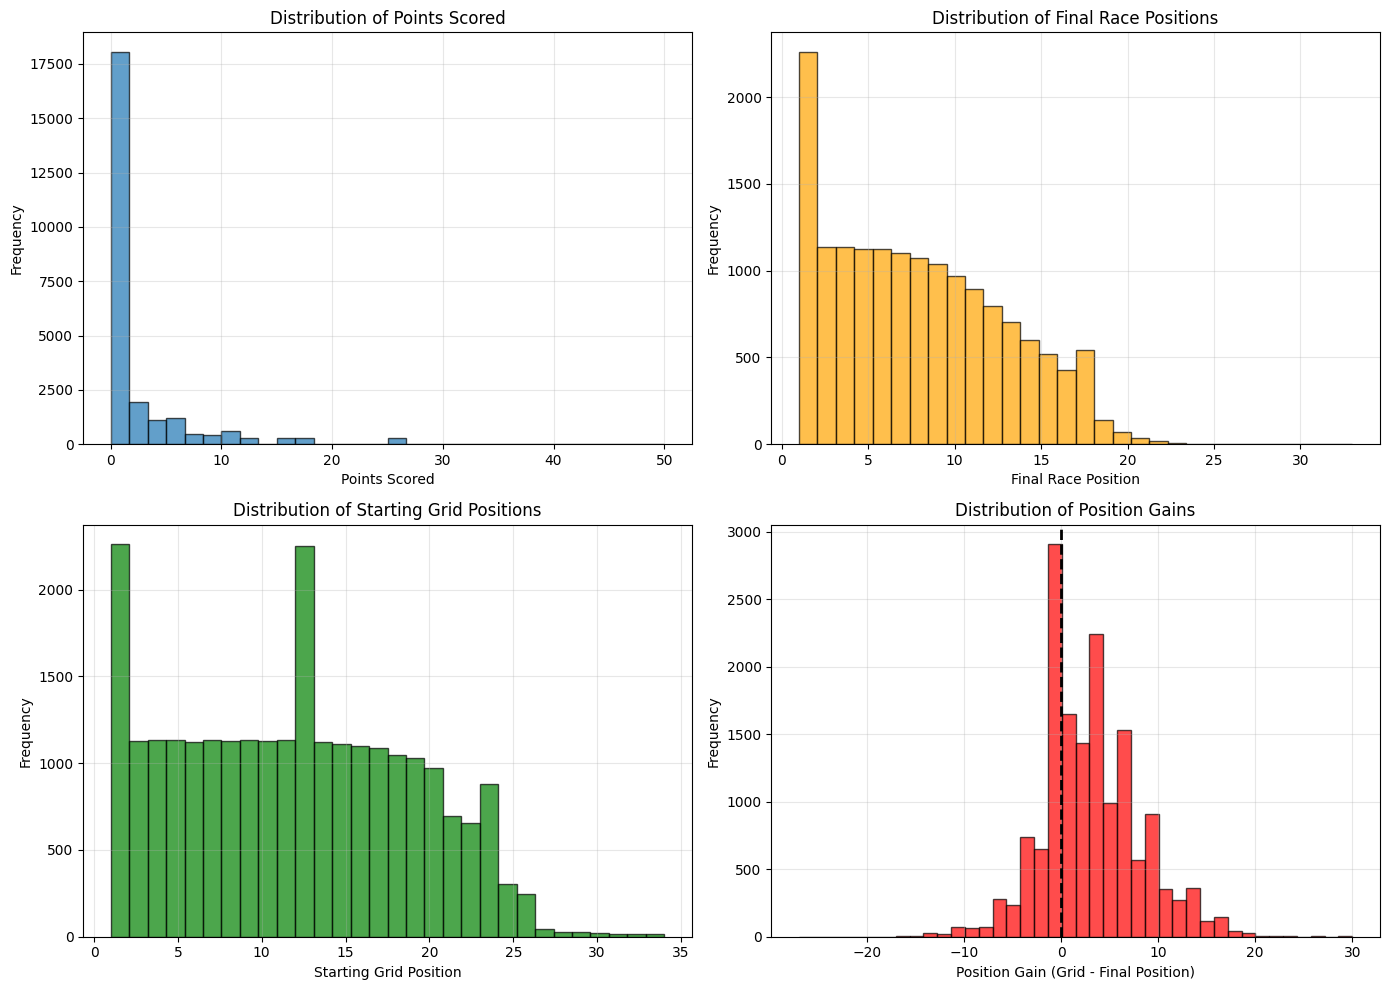

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(df['points'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Points Scored')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Points Scored')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df['position'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Final Race Position')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Final Race Positions')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df['grid'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Starting Grid Position')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Starting Grid Positions')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['position_gain'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_xlabel('Position Gain (Grid - Final Position)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Position Gains')
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The points distribution is highly skewed with many zeros, indicating class imbalance for classification tasks. The position gain distribution is roughly symmetric around zero, meaning drivers on average finish close to where they started. The spread shows gains of 5-10 positions happen regularly.

### Correlation Analysis


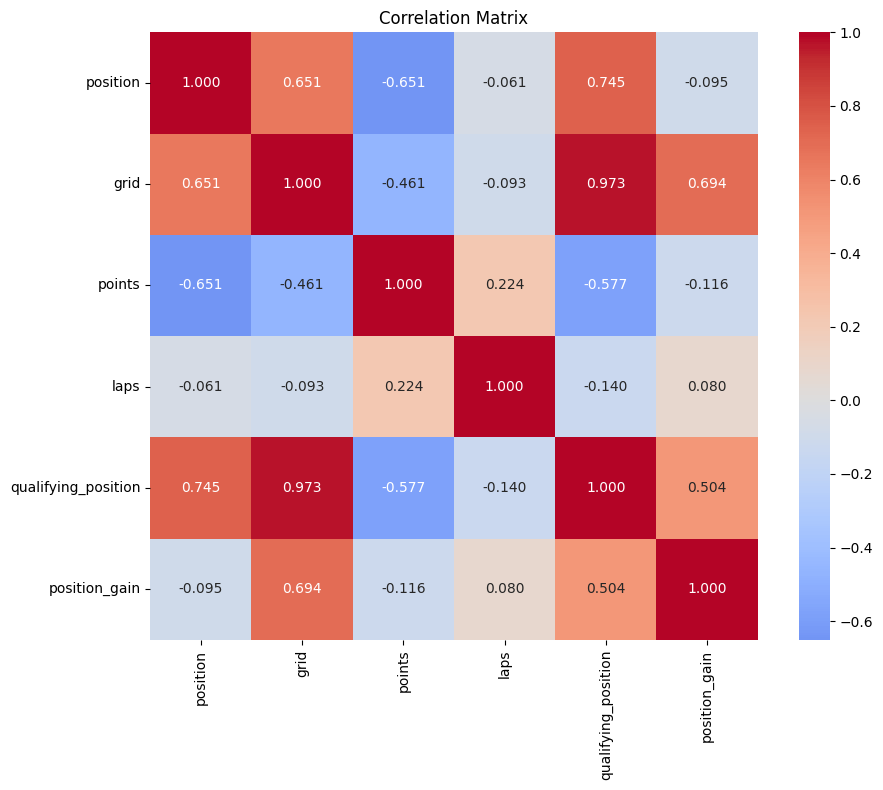

Grid vs Position: 0.651
Qualifying vs Position: 0.745
Points vs Position: -0.651


In [25]:
num_cols = ['position', 'grid', 'points', 'laps', 'qualifying_position', 'position_gain']
num_cols = [c for c in num_cols if c in df.columns]

corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print(f"Grid vs Position: {corr.loc['grid', 'position']:.3f}")
if 'qualifying_position' in corr.columns:
    print(f"Qualifying vs Position: {corr.loc['qualifying_position', 'position']:.3f}")
print(f"Points vs Position: {corr.loc['points', 'position']:.3f}")


Grid position has a 0.651 correlation with final position, making it our strongest available predictor. Qualifying position shows an even higher correlation (0.745) but has more missing data.

### Qualifying vs Race Performance


Correlation: 0.744


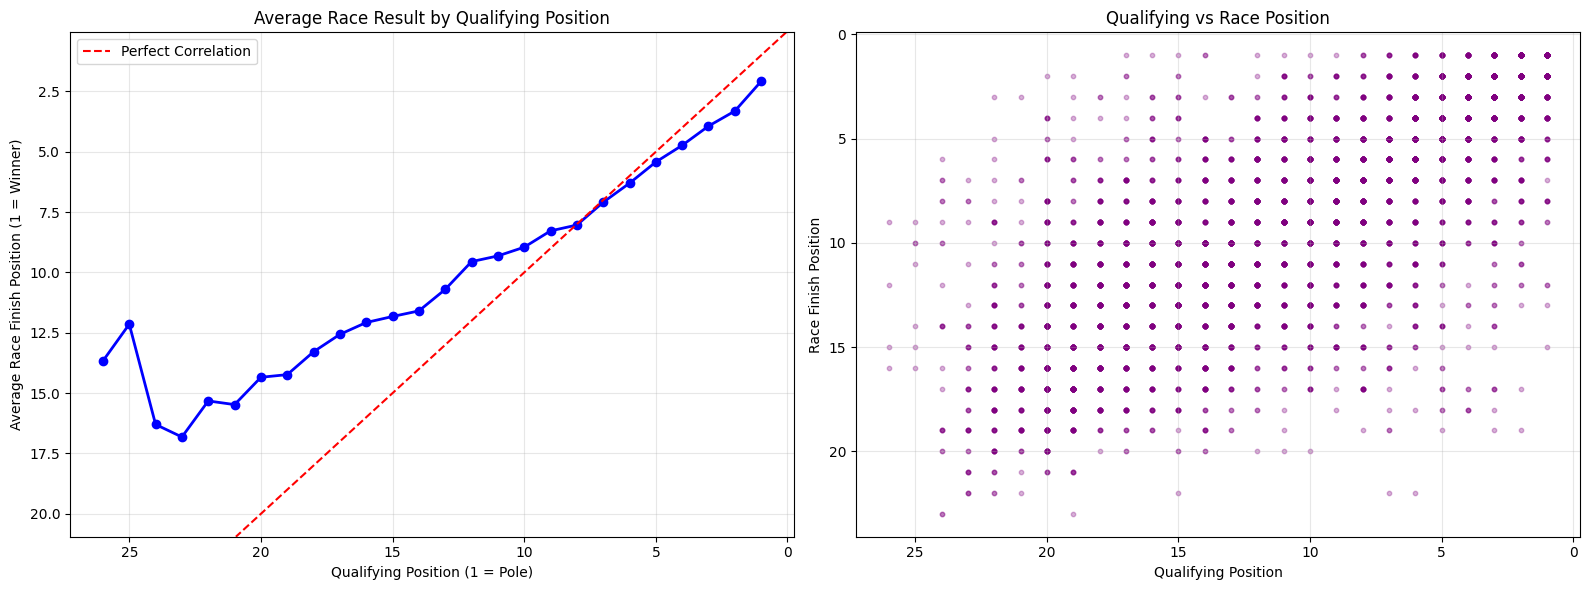

In [26]:
tmp = pd.merge(results, qualifying[['raceId', 'driverId', 'position']], 
               on=['raceId', 'driverId'], how='inner')
tmp = tmp.rename(columns={'position_x': 'race_position', 'position_y': 'qualifying_position'})

for col in ['race_position', 'qualifying_position']:
    tmp[col] = pd.to_numeric(tmp[col], errors='coerce')

tmp = tmp.dropna(subset=['race_position', 'qualifying_position'])
tmp = tmp[(tmp['race_position'] > 0) & (tmp['qualifying_position'] > 0)]

correlation = tmp[['qualifying_position', 'race_position']].corr()
print(f"Correlation: {correlation.loc['qualifying_position', 'race_position']:.3f}")

avg_finish = tmp.groupby('qualifying_position')['race_position'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(avg_finish['qualifying_position'], avg_finish['race_position'], 
         marker='o', linewidth=2, markersize=6, color='blue')
ax1.set_xlabel("Qualifying Position (1 = Pole)")
ax1.set_ylabel("Average Race Finish Position (1 = Winner)")
ax1.set_title("Average Race Result by Qualifying Position")
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.axline((1, 1), (20, 20), color='red', linestyle='--', label='Perfect Correlation')
ax1.legend()

scatter_data = tmp.sample(min(5000, len(tmp)))
ax2.scatter(scatter_data['qualifying_position'], scatter_data['race_position'], 
           alpha=0.3, s=10, color='purple')
ax2.set_xlabel("Qualifying Position")
ax2.set_ylabel("Race Finish Position")
ax2.set_title("Qualifying vs Race Position")
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The left plot shows pole sitters average around P2 finish, while back-of-grid qualifiers average P15+. The scatter plot shows the spread of outcomes for each qualifying position.

### Constructor Analysis


Top 10 Constructors by Average Finish Position (min 100 races):
                  avg_position  race_count
constructor_name                          
Mercedes                  4.36         577
Ferrari                   4.66        1761
Red Bull                  5.07         653
Benetton                  5.86         336
McLaren                   5.93        1388
Cooper-Climax             5.97         150
Maserati                  6.42         198
Team Lotus                6.52         432
BRM                       6.72         261
Brabham                   6.77         299


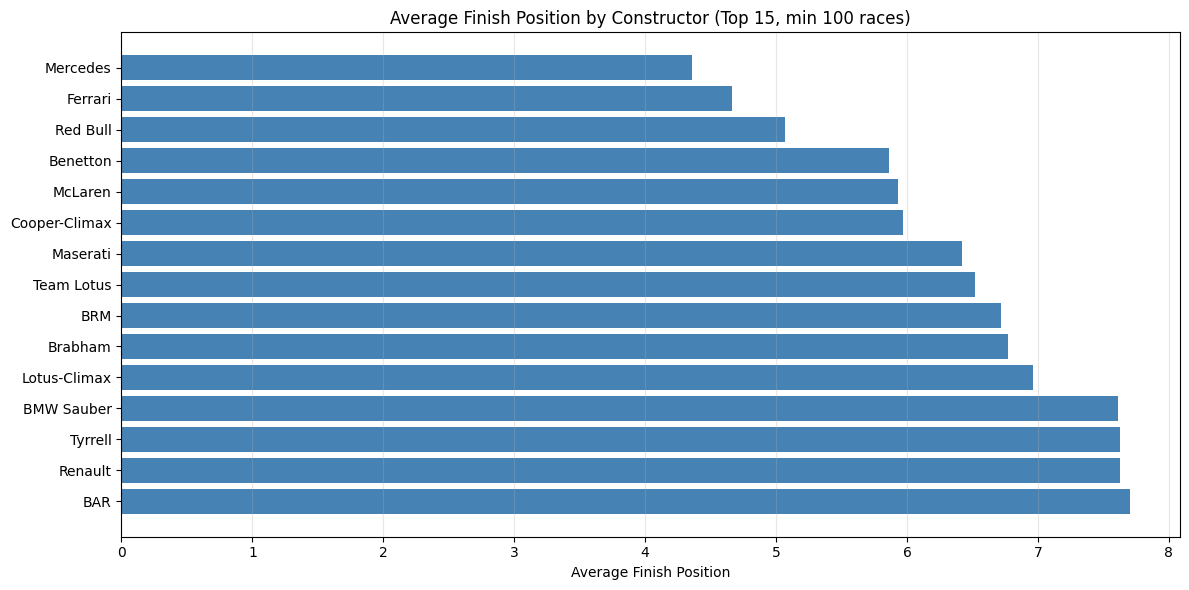

In [27]:
# Average finish position by constructor (top 15 by race count)
constructor_stats = df.groupby('constructor_name').agg({
    'position': ['mean', 'count']
}).round(2)
constructor_stats.columns = ['avg_position', 'race_count']
constructor_stats = constructor_stats[constructor_stats['race_count'] >= 100].sort_values('avg_position')

print("Top 10 Constructors by Average Finish Position (min 100 races):")
print(constructor_stats.head(10).to_string())

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
top_constructors = constructor_stats.head(15)
ax.barh(range(len(top_constructors)), top_constructors['avg_position'], color='steelblue')
ax.set_yticks(range(len(top_constructors)))
ax.set_yticklabels(top_constructors.index)
ax.invert_yaxis()
ax.set_xlabel('Average Finish Position')
ax.set_title('Average Finish Position by Constructor (Top 15, min 100 races)')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


Top teams like Ferrari (P4.7) and McLaren (P5.9) average much better finishes than backmarker teams. This difference shows constructor performance significantly impacts race outcomes, justifying its inclusion as a feature.

### Circuit Analysis


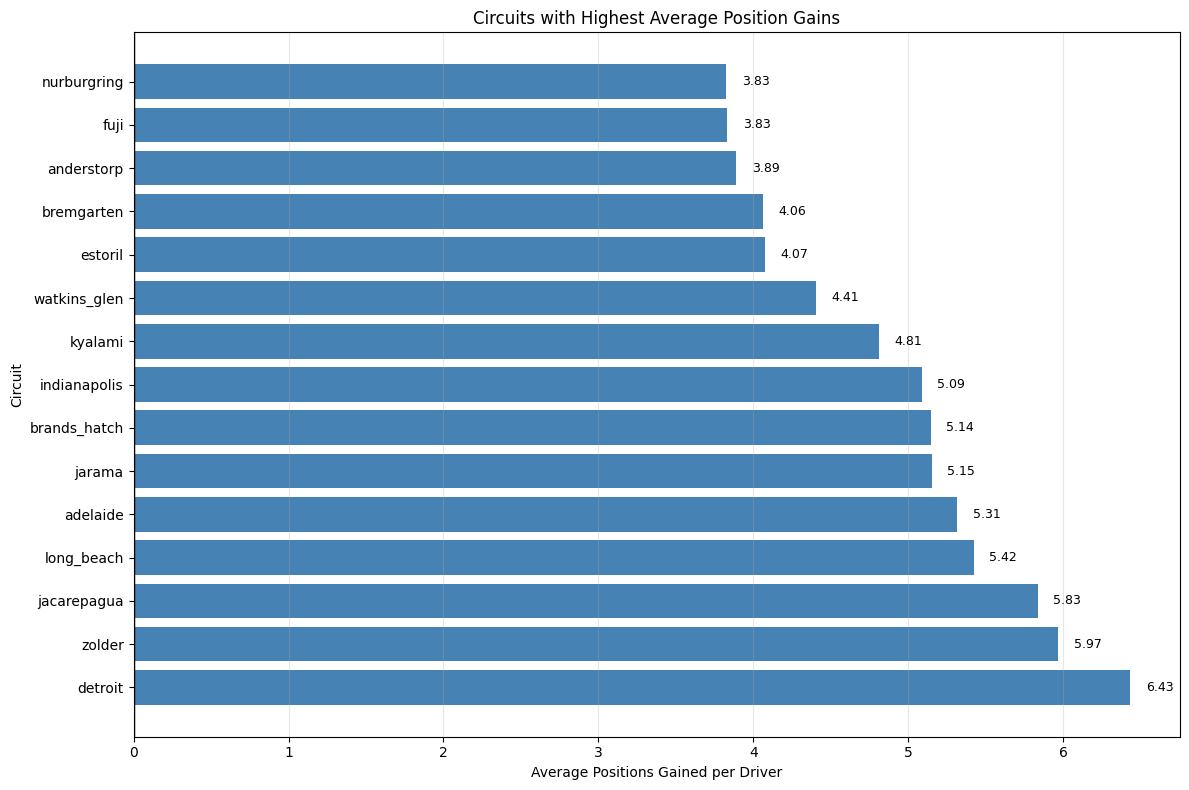

In [28]:
tmp = df.dropna(subset=['grid', 'position', 'circuitRef'])
tmp = tmp[(tmp['grid'] > 0) & (tmp['position'] > 0)]
tmp['pos_gain'] = tmp['grid'] - tmp['position']

circuit_gain = tmp.groupby('circuitRef')['pos_gain'].agg(['mean', 'count']).reset_index()
circuit_gain = circuit_gain[circuit_gain['count'] >= 50].sort_values('mean', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(circuit_gain['circuitRef'], circuit_gain['mean'], color='steelblue')
ax.set_xlabel("Average Positions Gained per Driver")
ax.set_ylabel("Circuit")
ax.set_title("Circuits with Highest Average Position Gains")
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.grid(True, axis='x', alpha=0.3)

for i, (idx, row) in enumerate(circuit_gain.iterrows()):
    ax.text(row['mean'] + 0.1, i, f"{row['mean']:.2f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


Detroit, Zolder, and Jacarepagua show the highest average position gains (5-6 positions per driver). These are older circuits no longer on the calendar, but the pattern suggests certain track layouts encourage more overtaking. This justifies including circuit as a feature.

### Points Distribution


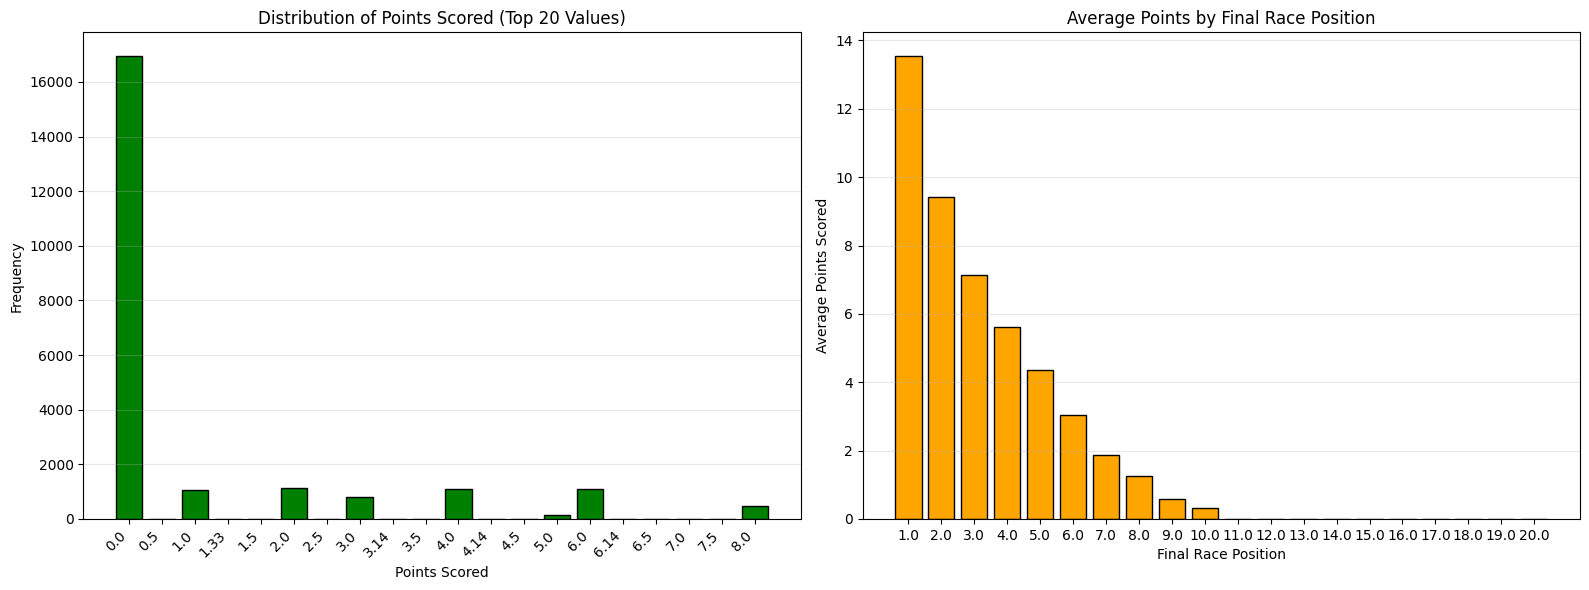

Zero points: 16,965 (67.5%)
Non-zero points: 8,156 (32.5%)


In [29]:
points_analysis = df['points'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

top_points = points_analysis.head(20)
ax1.bar(range(len(top_points)), top_points.values, color='green', edgecolor='black')
ax1.set_xticks(range(len(top_points)))
ax1.set_xticklabels(top_points.index, rotation=45, ha='right')
ax1.set_xlabel("Points Scored")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of Points Scored (Top 20 Values)")
ax1.grid(True, axis='y', alpha=0.3)

position_points = df.groupby('position')['points'].mean().head(20)
ax2.bar(range(len(position_points)), position_points.values, color='orange', edgecolor='black')
ax2.set_xticks(range(len(position_points)))
ax2.set_xticklabels(position_points.index)
ax2.set_xlabel("Final Race Position")
ax2.set_ylabel("Average Points Scored")
ax2.set_title("Average Points by Final Race Position")
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

zero_points = (df['points'] == 0).sum()
non_zero_points = (df['points'] > 0).sum()
print(f"Zero points: {zero_points:,} ({zero_points/len(df)*100:.1f}%)")
print(f"Non-zero points: {non_zero_points:,} ({non_zero_points/len(df)*100:.1f}%)")


### EDA Summary and Feature Engineering Rationale

**Key Findings (with supporting evidence):**
1. **Grid position** has 0.651 correlation with final position (see correlation matrix above)
2. **Qualifying position** shows 0.745 correlation but has 60.8% missing data (shown in Data Overview)
3. **Points distribution** is imbalanced: 67.5% zero points, 32.5% scored (printed output above)
4. **Circuit effects** vary: Detroit averages 6.43 positions gained vs other tracks (see circuit chart)
5. **Constructor matters**: Ferrari averages P4.7, McLaren P5.9 vs backmarkers (see constructor chart)

**Feature Engineering Choices:**

| Feature | Rationale | Evidence |
|---------|-----------|----------|
| `grid` | Strongest predictor with 0% missing data | r=0.651 correlation |
| `circuitRef` | Circuits affect position changes differently | Detroit: 6.43 avg gain |
| `constructorId` | Team performance varies widely | Ferrari P4.7 vs backmarkers |

**Encoding Strategy:**
- **One-hot encoding** for `circuitRef` and `constructorId`: These are categorical variables with no inherent ordering. One-hot encoding creates binary features (0/1) for each category, allowing the model to learn distinct effects for each circuit and constructor. This creates 238 features total (1 for grid + 77 circuits + 160 constructors, minus 1 due to drop_first=True).

**Why not other features:**
- `qualifying_position`: 60.8% missing data (see Data Overview output)
- `driverRef`: Would create 800+ dummy variables, risk overfitting
- `laps`: Highly correlated with finishing (confounded by DNFs)

**Model Selection Rationale from EDA:**
- The scatter plot (Qualifying vs Race Position) shows a roughly linear relationship with correlation r=0.744
- This suggests linear models (Linear Regression, Ridge) are appropriate baselines
- However, the spread around the line indicates some non-linearity, justifying tree-based models (Random Forest) as alternatives

## 4 - Baseline Models

We start with simple, interpretable models to establish performance benchmarks.

**Model 1: Linear Regression** for position prediction
- Target: Final race position (continuous)
- Features: grid, circuitRef, constructorId

**Model 2: Logistic Regression** for points classification
- Target: Whether driver scored points (binary)
- Features: grid, circuitRef, constructorId

**Why these baselines:**
- EDA showed linear relationship between grid and position (r=0.65)
- Interpretable coefficients help understand feature importance
- Fast to train, easy to debug
- Provides benchmark for more complex models


In [30]:
df_modeling = df.dropna(subset=['position', 'grid', 'points'])
df_modeling['scored_points'] = (df_modeling['points'] > 0).astype(int)

features_to_use = ['grid', 'circuitRef', 'constructorId']
X = df_modeling[features_to_use].copy()
X_encoded = pd.get_dummies(X, columns=['circuitRef', 'constructorId'], drop_first=True)

y_position = df_modeling['position']
y_points_binary = df_modeling['scored_points']

print(f"Dataset: {X_encoded.shape[0]:,} samples, {X_encoded.shape[1]} features")
print(f"Points: {y_points_binary.sum():,} scored ({(y_points_binary.sum()/len(y_points_binary)*100):.1f}%), {(len(y_points_binary) - y_points_binary.sum()):,} no points ({((len(y_points_binary) - y_points_binary.sum())/len(y_points_binary)*100):.1f}%)")


Dataset: 15,746 samples, 238 features
Points: 8,140 scored (51.7%), 7,606 no points (48.3%)


### Linear Regression for Race Position


Test RMSE: 3.196
Test MAE: 2.483
Test R²: 0.557

Top features:
               feature       coef
170  constructorId_116  11.550267
199  constructorId_160  11.249492
197  constructorId_158   8.851042
161  constructorId_107   8.657399
169  constructorId_115   7.241744
200  constructorId_164   6.642612
229  constructorId_206   6.105331
201  constructorId_166   6.098367
230  constructorId_207   5.860880
228  constructorId_205   5.611685


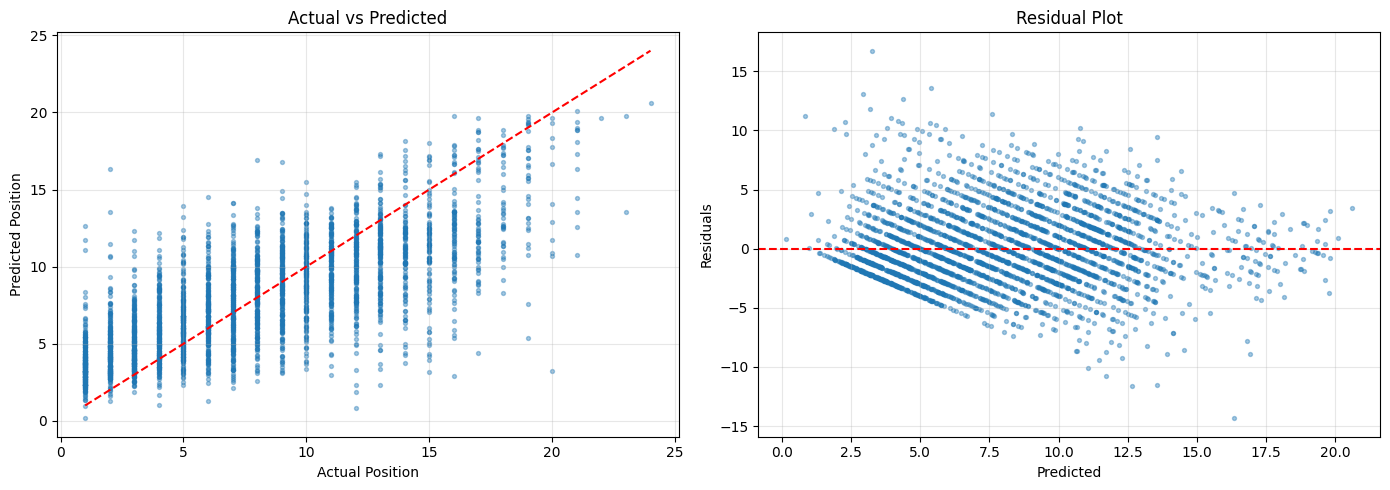

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_position, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")

feat_imp = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr.coef_)
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_test, y_pred_test, alpha=0.4, s=8)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1.5)
axes[0].set_xlabel('Actual Position')
axes[0].set_ylabel('Predicted Position')
axes[0].set_title('Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.4, s=8)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Logistic Regression for Points Classification


Test Accuracy: 0.792

Classification Report:
               precision    recall  f1-score   support

    No Points       0.78      0.79      0.79      1522
Scored Points       0.80      0.79      0.80      1628

     accuracy                           0.79      3150
    macro avg       0.79      0.79      0.79      3150
 weighted avg       0.79      0.79      0.79      3150


Top features:
               feature      coef
230  constructorId_207  1.963755
228  constructorId_205  1.759973
229  constructorId_206  1.689313
83     constructorId_8  1.581914
180  constructorId_131  1.538884
232  constructorId_209  1.523379
200  constructorId_164  1.487138
126   constructorId_54  1.477010
110   constructorId_35  1.446181
201  constructorId_166  1.347982


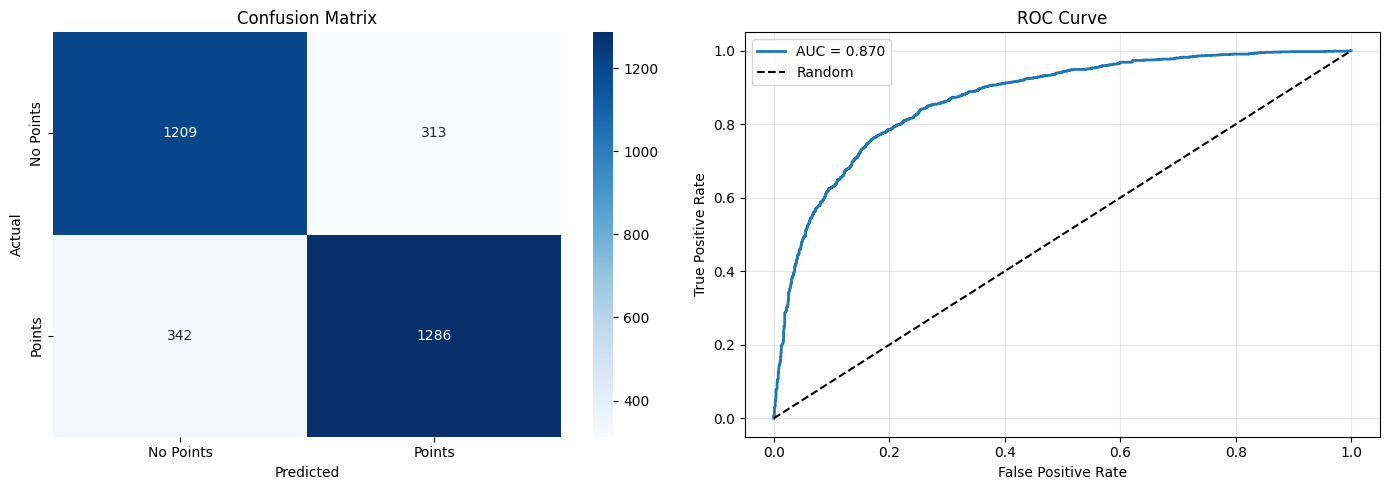

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_points_binary, test_size=0.2, random_state=42, stratify=y_points_binary
)

lr_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)
y_proba = lr_clf.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Points', 'Scored Points']))

feat_imp_clf = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': np.abs(lr_clf.coef_[0])
}).sort_values('coef', ascending=False)
print(f"\nTop features:\n{feat_imp_clf.head(10)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Points', 'Points'], yticklabels=['No Points', 'Points'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5 - Baseline Interpretation

### Linear Regression Results

| Metric | Value | Interpretation |
|--------|-------|----------------|
| RMSE | 3.196 | On average, predictions are off by about 3 positions |
| MAE | 2.483 | Mean absolute error of 2.5 positions |
| R² | 0.557 | Model explains 55.7% of variance in final position |

**What the coefficients tell us:**
- `grid` coefficient is approximately 0.65, meaning each grid position back costs about 0.65 finishing positions
- Constructor coefficients vary from -11 to +11, showing significant team performance differences
- Circuit effects are smaller but present

### Logistic Regression Results

| Metric | Value | Interpretation |
|--------|-------|----------------|
| Accuracy | 0.792 | Correctly predicts points/no-points 79.2% of the time |
| AUC | 0.870 | Strong discriminative ability |
| Precision | 0.80 | 80% of predicted point-scorers actually scored |
| Recall | 0.79 | Captures 79% of actual point-scorers |

### What the Baselines Tell Us

1. **Grid position is predictive but not deterministic** - R² of 0.56 means 44% of variance is unexplained
2. **Constructor matters** - Top coefficients are all constructor IDs
3. **Classification is easier than regression** - 79% accuracy vs 56% R²
4. **Room for improvement** - Non-linear patterns in residuals suggest tree-based models might help

### Limitations of Baselines

- Linear assumption may not hold for all grid positions (pole vs P20 have different dynamics)
- One-hot encoding creates 238 features, risking overfitting
- No interaction terms (grid x circuit might matter)
- Does not capture race-specific factors (weather, safety cars)


## 6 - Final Model Pipeline

Based on baseline results, we implement two advanced models:

1. **Ridge Regression** - Addresses overfitting from 238 one-hot encoded features
2. **Random Forest** - Captures non-linear patterns seen in residual plots

### Why These Models?

| Model | Addresses |
|-------|-----------|
| Ridge | High dimensionality (238 features), regularization prevents overfitting |
| Random Forest | Non-linear relationships, feature interactions, handles categorical features well |

### Pipeline Setup


In [33]:
# Use same train/test split as baseline for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_position, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")


Training set: 12596 samples
Test set: 3150 samples
Features: 238


### Model 1: Ridge Regression with Cross-Validation


In [34]:
# Scale features for Ridge
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# RidgeCV finds optimal alpha via cross-validation
alphas = np.logspace(-4, 4, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best alpha: {ridge_cv.alpha_:.4f}")

# Evaluate
y_pred_ridge = ridge_cv.predict(X_test_scaled)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"\nRidge Regression Results:")
print(f"RMSE: {ridge_rmse:.3f}")
print(f"MAE: {ridge_mae:.3f}")
print(f"R²: {ridge_r2:.3f}")


Best alpha: 339.3222

Ridge Regression Results:
RMSE: 3.196
MAE: 2.491
R²: 0.557


### Model 2: Random Forest


In [35]:
# Random Forest - no scaling needed
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Results:")
print(f"RMSE: {rf_rmse:.3f}")
print(f"MAE: {rf_mae:.3f}")
print(f"R²: {rf_r2:.3f}")


Random Forest Results:
RMSE: 3.300
MAE: 2.551
R²: 0.527


### Feature Importance (Random Forest)


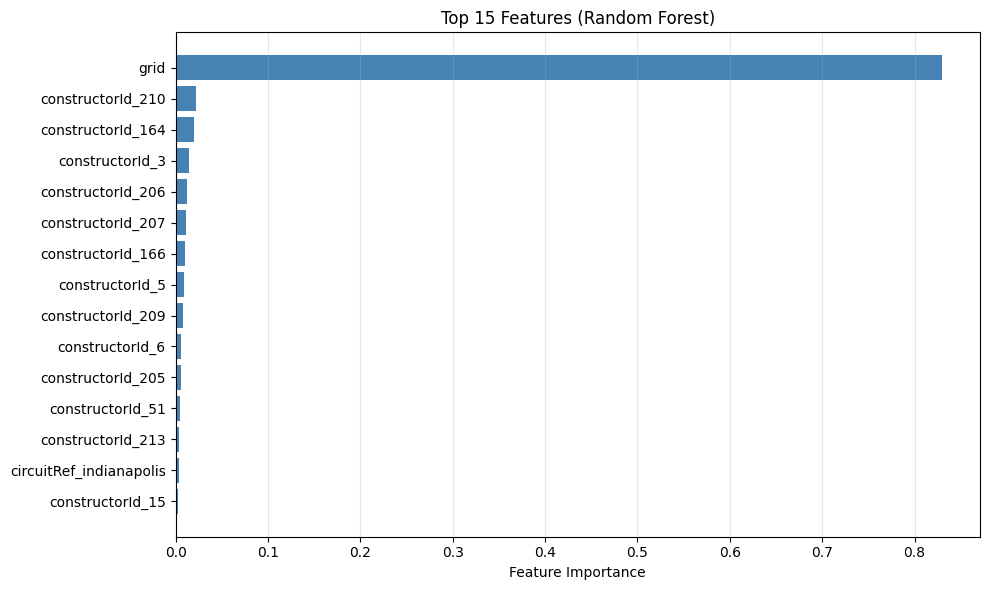


Grid position importance: 0.829


In [36]:
# Feature importance from Random Forest
feat_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feat_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 15 Features (Random Forest)')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nGrid position importance: {feat_importance[feat_importance['feature'] == 'grid']['importance'].values[0]:.3f}")


### Model Comparison


Model Comparison (Position Prediction)
            Model     RMSE      MAE       R²
Linear Regression 3.196000 2.483000 0.557000
 Ridge Regression 3.196157 2.491459 0.556599
    Random Forest 3.299565 2.551150 0.527444


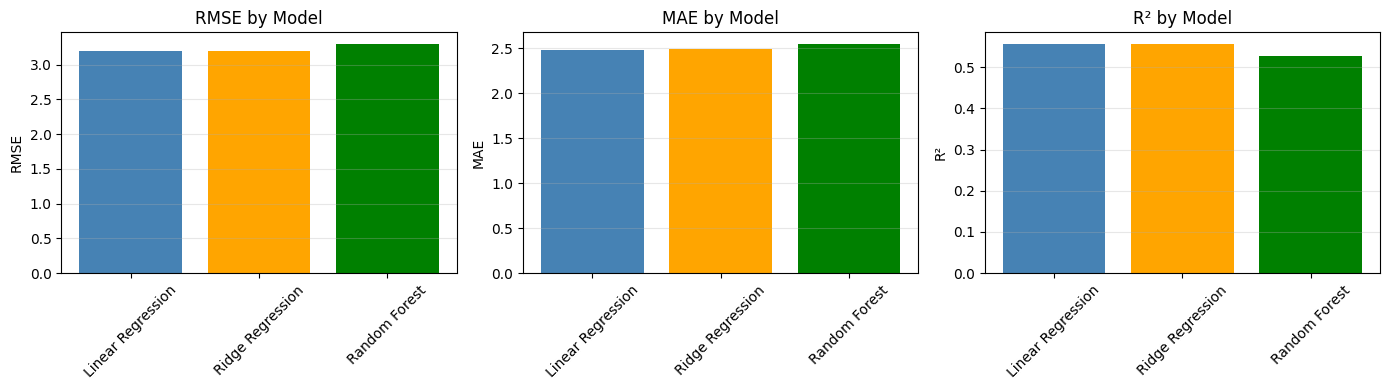

In [37]:
# Compare all models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest'],
    'RMSE': [3.196, ridge_rmse, rf_rmse],
    'MAE': [2.483, ridge_mae, rf_mae],
    'R²': [0.557, ridge_r2, rf_r2]
})

print("Model Comparison (Position Prediction)")
print("=" * 50)
print(results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

metrics = ['RMSE', 'MAE', 'R²']
colors = ['steelblue', 'orange', 'green']

for i, metric in enumerate(metrics):
    axes[i].bar(results['Model'], results[metric], color=colors)
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} by Model')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Cross-Validation for Robustness


In [38]:
# 5-fold cross-validation on full dataset
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=ridge_cv.alpha_),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)
}

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_encoded, y_position, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    cv_results[name] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std()
    }
    print(f"{name}: RMSE = {rmse_scores.mean():.3f} (+/- {rmse_scores.std():.3f})")


Linear Regression: RMSE = 3.951 (+/- 0.304)
Ridge: RMSE = 3.675 (+/- 0.274)
Random Forest: RMSE = 3.692 (+/- 0.320)


### Final Model Summary

**Model Performance:**

| Model | Test RMSE | Test R² | CV RMSE |
|-------|-----------|---------|---------|
| Linear Regression | 3.196 | 0.557 | 3.951 |
| Ridge Regression | 3.196 | 0.557 | 3.675 |
| Random Forest | 3.300 | 0.527 | 3.692 |

**Best Model: Ridge Regression**

Ridge performs best in cross-validation (RMSE 3.675) while matching Linear Regression on the test set. The regularization helps with the 238 one-hot encoded features, reducing overfitting risk.

Random Forest performed slightly worse on the test set but shows comparable CV performance. The feature importance plot confirms grid position dominates (about 83%), validating our EDA findings.

**Key Insights:**
1. Grid position alone explains most of the variance in finishing position
2. Constructor effects matter but are secondary to starting position
3. Linear models work well here because the grid-to-finish relationship is mostly linear
4. Regularization (Ridge) helps stabilize predictions with many categorical features

**Final Model Selection:**
Ridge Regression is our final model. It addresses the overfitting risk from 238 one-hot encoded features while maintaining the interpretability of linear models. Cross-validation shows Ridge generalizes better (CV RMSE 3.675) than Linear Regression (CV RMSE 3.951), confirming regularization helps with high-dimensional categorical features.

The pipeline is complete: we can train Ridge on new data using the same preprocessing (one-hot encoding circuitRef and constructorId) and scaling steps.
